In [20]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator
from utils.modes.axicon import Axicon


device = 'cuda:3'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


truncate_circle = True

Load the Modes and the derivatives

In [21]:
microlens = 30 
size = microlens

n_zernike_rows = 7
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

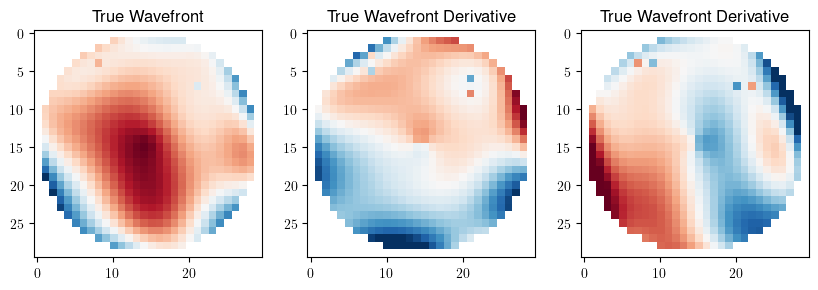

In [22]:
wavefront = torch.zeros(size,size)

# decenter = [0.2,-0.1] #lets say we're off center...
decenter = [0,0] #lets say we're off center...

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=truncate_circle, pixel_basis = True, special_mode=Axicon)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(3,n_zernike)
# np.random.shuffle(elements)
# elements = elements[:5]
zer_coeffs = torch.randn(len(elements),1,1) * 0.5


mode_coeffs[elements] = zer_coeffs

mode_coeffs[n_zernike] = 5

mode_coeffs[260] = 1 # we have some noise
mode_coeffs[157] = -1 # we have some noise

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront, cmap='RdBu'); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1, cmap='RdBu'); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1, cmap='RdBu'); ax[2].set_title('True Wavefront Derivative')

In [23]:
zerns = np.nan_to_num(modes[:n_zernike])
axicon = np.nan_to_num(modes[n_zernike:n_zernike+1])

axicon /= np.sqrt((axicon*axicon).sum())
zerns /= np.sqrt((zerns*zerns).sum((1,2), keepdims=True))


coeffs = (axicon * zerns).sum((1,2))

## From here I show once we have gradients


In [24]:
sampled_gradient = wavefront_deriv.clone()
# sampled_gradient[:,10,10] = np.nan

sampled_gradient+=torch.randn_like(sampled_gradient)*0.05 * torch.max(torch.nan_to_num(sampled_gradient))

num_inits = 25

evaller = ModalEvaluator(size=(size,size), initializations=num_inits, n_zernike_rows=n_zernike_rows, zern_transform=False, pixel_basis=True, special_mode=Axicon, device=device)

In [25]:
init_transX, init_transY = np.meshgrid(np.linspace(-.2, .2, 5), np.linspace(-.2, .2, 5))

init_rot, init_transX, init_transY = [0.]*num_inits, init_transX.flatten(), init_transY.flatten()

coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=14000, lr=4e-3, l1_reg=5e-4)#, fit_params=coeffs)

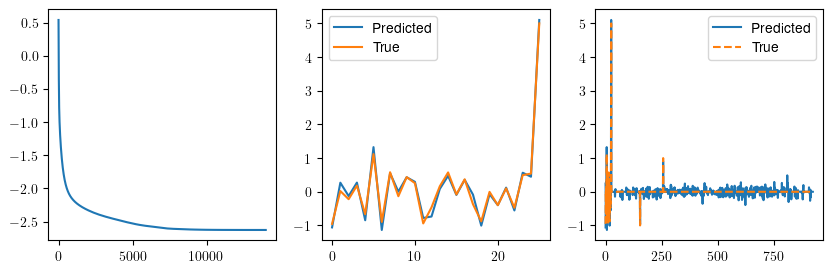

In [26]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][evaller.best_init,3:n_zernike+1].detach().cpu())
ax[1].plot(mode_coeffs[3:n_zernike+1,0,0])
ax[1].legend(['Predicted','True'])
ax[2].plot(coeffs['coefficients'][evaller.best_init,3:].detach().cpu())
ax[2].plot(mode_coeffs[3:,0,0],'--')
ax[2].legend(['Predicted','True'])

In [84]:
all_coeffs = []
best_inits = []
l1_reg = [5e-4, 5e-4, 5e-4]

for n,noise_level in enumerate([0, 0.02, 0.05]):
    sampled_gradient = wavefront_deriv.clone()

    # ptp = sampled_gradient[~torch.isnan(sampled_gradient)].max() - sampled_gradient[~torch.isnan(sampled_gradient)].min()

    sampled_gradient+=torch.randn_like(sampled_gradient)*noise_level * torch.max(torch.nan_to_num(sampled_gradient)) #ptp

    coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=14000, lr=5e-3, l1_reg=l1_reg[n])

    all_coeffs.append(coeffs)
    best_inits.append(evaller.best_init)


/home/s/Sunny.Howard/overdictionary/utils/models/modalevaluator.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavefront_derivs = torch.tensor(wavefront_derivs).permute(1,0).tile(self.initializations,1).float().to(self.device)


In [85]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [86]:
from matplotlib import rc

# Set the font family to serif and specify Times New Roman
rc('font',**{'family':'serif','serif':['CMU Serif Roman']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Enable LaTeX for text rendering
rc('text', usetex=True)

In [91]:
def mean_zero(wavefront, measured_wavefront):
    #shack hartmann is blind to piston, so find the intercept that minimizes error with measured
    # if wavefront is a tensor, make it a numpy
    if isinstance(wavefront, torch.Tensor):
        wavefront = wavefront.numpy()
    
    # if measured_wavefront is a tensor, make it a numpy
    if isinstance(measured_wavefront, torch.Tensor):
        measured_wavefront = measured_wavefront.numpy()

    
    wavefront = wavefront - np.nanmax(wavefront) + np.nanmax(measured_wavefront)
    
    return wavefront 

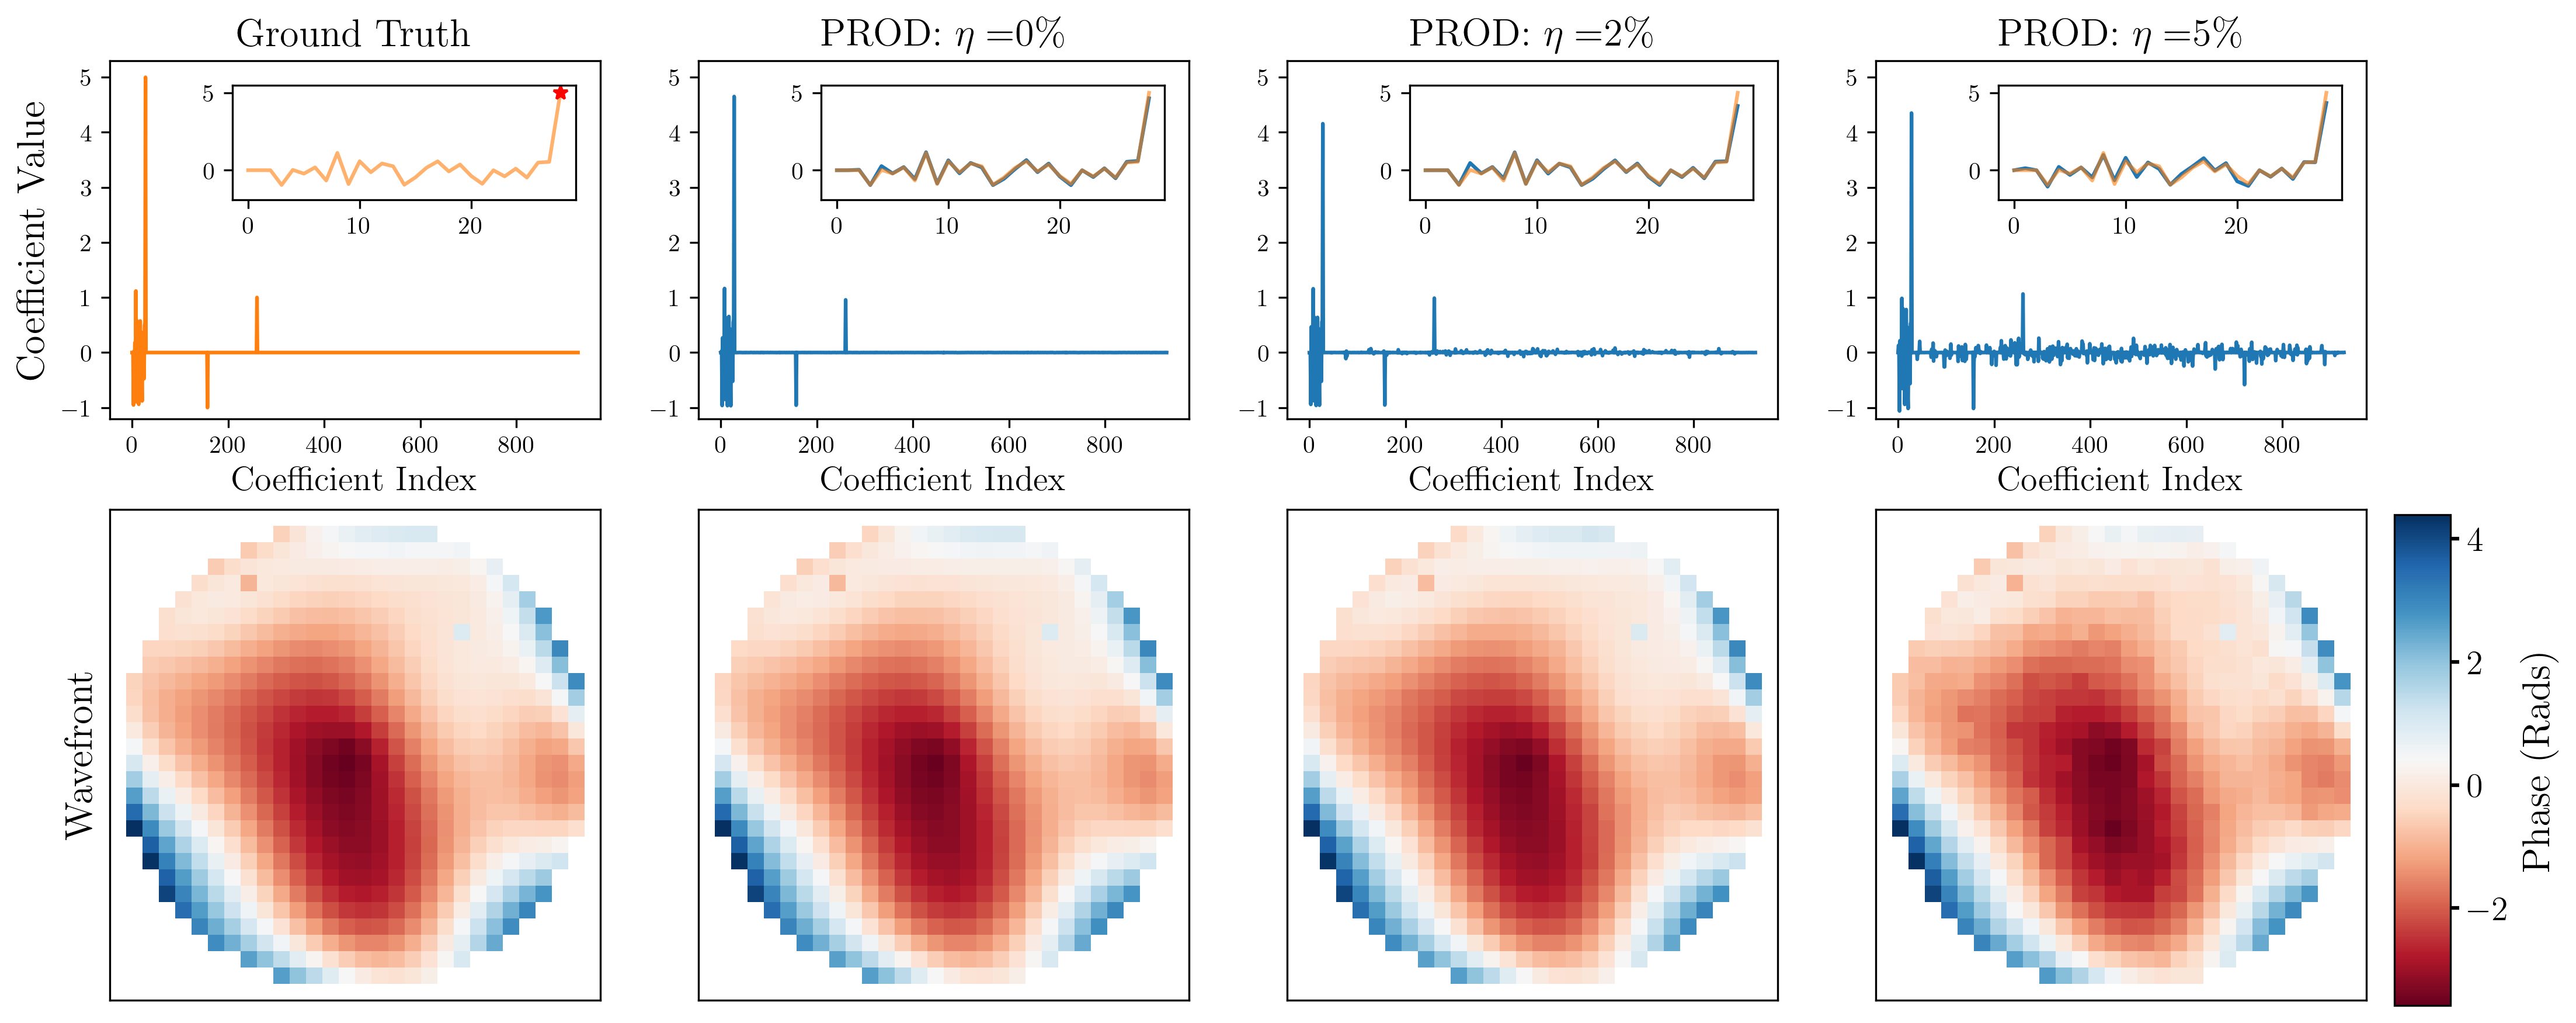

In [94]:
noise_levels = [0, 2, 5]
fig,ax = plt.subplots(2,4,figsize=(16,7), height_ratios=[1,1.4], dpi=300)

ax[0,0].plot(mode_coeffs.detach().cpu().numpy()[:,0,0], color='#ff7f0e')
ax[0,0].set_ylim(-1.2,5.3)
sub_ax = inset_axes(
parent_axes=ax[0,0],
width="70%",
height="32%",
borderpad=1 # padding between parent and inset axes
)
sub_ax.plot(mode_coeffs.detach().cpu().numpy()[:29,0,0], alpha=.6, color='#ff7f0e')
sub_ax.plot(n_zernike, mode_coeffs[n_zernike].detach().cpu().numpy(), 'r*')
sub_ax.set_ylim(-1.9,5.5)


ax[0,0].set_title(f'Ground Truth', fontsize=16)
ax[0,0].set_xlabel('Coefficient Index', fontsize = 14)

ax[1,0].imshow(mean_zero(wavefront, wavefront), cmap='RdBu')
ax[1,0].set_yticks([]); ax[1,0].set_xticks([])

vmax = torch.nan_to_num(wavefront).max()
vmin = torch.nan_to_num(wavefront).min()


for i in range(3):
    ax[0,i+1].plot(all_coeffs[i]['coefficients'][best_inits[i]].detach().cpu().numpy())
    # ax[i].plot(mode_coeffs.detach().cpu().numpy()[:,0,0])
    ax[0,i+1].set_ylim(-1.2,5.3)
    sub_ax = inset_axes(
    parent_axes=ax[0,i+1],
    width="70%",
    height="32%",
    borderpad=1  # padding between parent and inset axes
    )
    sub_ax.plot(all_coeffs[i]['coefficients'][best_inits[i],:29].detach().cpu().numpy())
    sub_ax.plot(mode_coeffs.detach().cpu().numpy()[:29,0,0], alpha=.6)
    sub_ax.set_ylim(-1.9,5.5)

    ax[0,i+1].set_title(f'PROD: $\eta = ${noise_levels[i]}\%', fontsize=16 )
    ax[0,i+1].set_xlabel('Coefficient Index', fontsize = 14)

    wavefront_pred, derivs_pred =  evaller.get_wavefront(all_coeffs[i], microlens_pitch=1, best_init=best_inits[i])

    im = ax[1, i+1].imshow(mean_zero(wavefront_pred, wavefront),vmax=vmax,vmin=vmin, cmap='RdBu')
    ax[1,i+1].set_yticks([]); ax[1,i+1].set_xticks([])

#make more space on right for color bar
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.94, 0.11, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax, label='Phase (Rads)')
#make the ticks bigger
cbar_ax.yaxis.set_tick_params(width=1.5)
cbar_ax.yaxis.set_tick_params(width=1.5)
cbar_ax.yaxis.label.set_size(16)
cbar_ax.yaxis.set_tick_params(labelsize=14)



ax[0,0].set_ylabel('Coefficient Value', fontsize=16)
ax[1,0].set_ylabel('Wavefront', fontsize=16)

fig.savefig('figs/axicon.png', bbox_inches='tight',dpi=300)